In [ ]:
# Cell 1 — Imports

import numpy as np
import pandas as pd

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from tqdm.auto import tqdm
import matplotlib.pyplot as plt


In [ ]:
# Cell 2 — Load a "typical CSV classification dataset" from sklearn
# We'll load Breast Cancer (binary classification), then write it to CSV and read it back.
# Pretty ignorable, varies per problem

data = load_breast_cancer()
X = data.data
y = data.target  # 0/1 labels
feature_names = data.feature_names

df = pd.DataFrame(X, columns=feature_names)
df["target"] = y

csv_path = "breast_cancer.csv"
df.to_csv(csv_path, index=False)

# Read it back like a typical CSV workflow
df_csv = pd.read_csv(csv_path)

print("CSV shape:", df_csv.shape)
df_csv.head()


CSV shape: (569, 31)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [ ]:
# Cell 3 — Train/val/test split + scaling + DataLoaders
# Some complex scary looking stuff that isn't actually scary

# Separate features/labels
X = df_csv.drop(columns=["target"]).values.astype(np.float32)
y = df_csv["target"].values.astype(np.int64)

# Split: train vs temp, then temp -> val/test
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

# Scale features (important for nn so gradients behave nicely)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).astype(np.float32)
X_val   = scaler.transform(X_val).astype(np.float32)
X_test  = scaler.transform(X_test).astype(np.float32)

# Convert to tensors because neural nets like tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)  # float for BCEWithLogitsLoss
X_val_t   = torch.tensor(X_val, dtype=torch.float32)
y_val_t   = torch.tensor(y_val, dtype=torch.float32)
X_test_t  = torch.tensor(X_test, dtype=torch.float32)
y_test_t  = torch.tensor(y_test, dtype=torch.float32)

# Datasets + loaders
batch_size = 64

# For most pytorch related data problems, instead of streaming from storage,
# We use the 'Dataset' class to prepare our input for the dataloader.
# The below steps are pretty standardized

# First you create a Dataset based on the TensorDataset class
train_ds = TensorDataset(X_train_t, y_train_t)
val_ds   = TensorDataset(X_val_t, y_val_t)
test_ds  = TensorDataset(X_test_t, y_test_t)

# Dataloader takes the dataset and creates batches of samples for you
# Here you can also control cpu workers, shuffle, caching, etc.
# I've skipped those for now
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

print("Train/Val/Test sizes:", len(train_ds), len(val_ds), len(test_ds))

Train/Val/Test sizes: 398 85 86


In [ ]:
# Cell 4 — Define a basic ANN (MLP) in PyTorch + layer explanations

class SimpleANN(nn.Module):
    """
    A simple feed-forward neural network for binary classification.
    Layers here - https://docs.pytorch.org/docs/stable/nn.html

    Layers explained:
    - nn.Linear(in_features, out_features):
        A fully-connected (dense) layer: output = XW + b
    - nn.ReLU():
        Nonlinearity. Without this, stacking Linear layers collapses into one Linear.
        We can use other activations too, feel free to experiment
        Activations found here:
            https://docs.pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity
            https://docs.pytorch.org/docs/stable/nn.html#non-linear-activations-other

    - Final nn.Linear(..., 1):
        Produces a single logit (raw score). We'll use BCEWithLogitsLoss.
    """
    def __init__(self, input_dim: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),

            nn.Linear(32, 16),
            nn.ReLU(),

            nn.Linear(16, 8),
            nn.ReLU(),

            nn.Linear(8, 1)  # 1 logit for binary classification
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

input_dim = X_train.shape[1]
print(input_dim)
model = SimpleANN(input_dim)

# Print the model itself after initializing it
print(model)


30
SimpleANN(
  (net): Sequential(
    (0): Linear(in_features=30, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=8, bias=True)
    (5): ReLU()
    (6): Linear(in_features=8, out_features=1, bias=True)
  )
)


In [ ]:
# Cell 5 — Training setup (device, loss, optimizer, hyperparameters)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

lr = 1e-3
epochs = 25

loss_function = nn.BCEWithLogitsLoss()  # Seemed decent for this case
# Other loss functions - https://docs.pytorch.org/docs/stable/nn.html#loss-functions
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

def logits_to_preds(logits: torch.Tensor) -> torch.Tensor:
    """
    Convert logits -> probabilities -> binary predictions (0/1).
    """
    probs = torch.sigmoid(logits)
    return (probs >= 0.5).to(torch.int64)


In [ ]:
# Cell 6 — Train/validation loops with tqdm + metric tracking

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(1, epochs + 1):
    # ---- Training ----
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # This training loop shows batch-wise gradient updates btw
    # Each value, xb, yb, is a batch of input and output, as we iterate through
    # the dataloader
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs} [train]", leave=False)
    for xb, yb in train_pbar:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()

        # Forward pass
        logits = model(xb).squeeze(1)     # shape: (batch,)

        # Loss calculation
        loss = loss_function(logits, yb)      # yb should be float for BCE

        # Back propagation
        loss.backward()

        # Gradient update (updates parameters/weights)
        optimizer.step()

        # Logging
        running_loss += loss.item() * xb.size(0)

        preds = logits_to_preds(logits).detach()
        correct += (preds.cpu() == yb.cpu().to(torch.int64)).sum().item()
        total += xb.size(0)

        train_pbar.set_postfix(loss=loss.item())

    epoch_train_loss = running_loss / total
    epoch_train_acc = correct / total

    train_losses.append(epoch_train_loss)
    train_accs.append(epoch_train_acc)

    # ---- Validation ----
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():  # No tracking gradients for validation set
        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch}/{epochs} [val]", leave=False)
        for xb, yb in val_pbar:
            xb = xb.to(device)
            yb = yb.to(device)

            # Forward pass
            logits = model(xb).squeeze(1)

            # Loss compute
            loss = loss_function(logits, yb)

            # Logging
            val_running_loss += loss.item() * xb.size(0)

            preds = logits_to_preds(logits)
            val_correct += (preds.cpu() == yb.cpu().to(torch.int64)).sum().item()
            val_total += xb.size(0)

            val_pbar.set_postfix(val_loss=loss.item())

    epoch_val_loss = val_running_loss / val_total
    epoch_val_acc = val_correct / val_total

    val_losses.append(epoch_val_loss)
    val_accs.append(epoch_val_acc)

    print(
        f"Epoch {epoch:02d}/{epochs} | "
        f"train_loss={epoch_train_loss:.4f}, train_acc={epoch_train_acc:.4f} | "
        f"val_loss={epoch_val_loss:.4f}, val_acc={epoch_val_acc:.4f}"
    )


Epoch 1/25 [train]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 1/25 [val]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 01/25 | train_loss=0.6744, train_acc=0.6281 | val_loss=0.6639, val_acc=0.6235


Epoch 2/25 [train]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 2/25 [val]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 02/25 | train_loss=0.6538, train_acc=0.6281 | val_loss=0.6452, val_acc=0.6353


Epoch 3/25 [train]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 3/25 [val]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 03/25 | train_loss=0.6334, train_acc=0.6407 | val_loss=0.6229, val_acc=0.6588


Epoch 4/25 [train]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 4/25 [val]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 04/25 | train_loss=0.6103, train_acc=0.7111 | val_loss=0.5945, val_acc=0.7059


Epoch 5/25 [train]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 5/25 [val]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 05/25 | train_loss=0.5780, train_acc=0.8266 | val_loss=0.5571, val_acc=0.8824


Epoch 6/25 [train]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 6/25 [val]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 06/25 | train_loss=0.5358, train_acc=0.8995 | val_loss=0.5115, val_acc=0.9412


Epoch 7/25 [train]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 7/25 [val]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 07/25 | train_loss=0.4892, train_acc=0.9271 | val_loss=0.4620, val_acc=0.9529


Epoch 8/25 [train]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 8/25 [val]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 08/25 | train_loss=0.4413, train_acc=0.9372 | val_loss=0.4148, val_acc=0.9647


Epoch 9/25 [train]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 9/25 [val]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 09/25 | train_loss=0.3971, train_acc=0.9497 | val_loss=0.3722, val_acc=0.9882


Epoch 10/25 [train]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 10/25 [val]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 10/25 | train_loss=0.3574, train_acc=0.9573 | val_loss=0.3333, val_acc=0.9882


Epoch 11/25 [train]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 11/25 [val]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 11/25 | train_loss=0.3202, train_acc=0.9648 | val_loss=0.2976, val_acc=0.9882


Epoch 12/25 [train]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 12/25 [val]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 12/25 | train_loss=0.2843, train_acc=0.9724 | val_loss=0.2632, val_acc=0.9882


Epoch 13/25 [train]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 13/25 [val]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 13/25 | train_loss=0.2487, train_acc=0.9749 | val_loss=0.2285, val_acc=0.9882


Epoch 14/25 [train]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 14/25 [val]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 14/25 | train_loss=0.2125, train_acc=0.9774 | val_loss=0.1952, val_acc=0.9882


Epoch 15/25 [train]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 15/25 [val]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 15/25 | train_loss=0.1788, train_acc=0.9774 | val_loss=0.1643, val_acc=0.9882


Epoch 16/25 [train]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 16/25 [val]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 16/25 | train_loss=0.1495, train_acc=0.9774 | val_loss=0.1371, val_acc=0.9882


Epoch 17/25 [train]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 17/25 [val]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 17/25 | train_loss=0.1253, train_acc=0.9774 | val_loss=0.1154, val_acc=0.9882


Epoch 18/25 [train]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 18/25 [val]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 18/25 | train_loss=0.1069, train_acc=0.9774 | val_loss=0.0989, val_acc=0.9882


Epoch 19/25 [train]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 19/25 [val]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 19/25 | train_loss=0.0933, train_acc=0.9774 | val_loss=0.0874, val_acc=0.9882


Epoch 20/25 [train]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 20/25 [val]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 20/25 | train_loss=0.0840, train_acc=0.9799 | val_loss=0.0785, val_acc=0.9882


Epoch 21/25 [train]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 21/25 [val]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 21/25 | train_loss=0.0768, train_acc=0.9799 | val_loss=0.0717, val_acc=0.9882


Epoch 22/25 [train]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 22/25 [val]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 22/25 | train_loss=0.0716, train_acc=0.9849 | val_loss=0.0663, val_acc=0.9882


Epoch 23/25 [train]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 23/25 [val]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 23/25 | train_loss=0.0666, train_acc=0.9849 | val_loss=0.0637, val_acc=0.9765


Epoch 24/25 [train]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 24/25 [val]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 24/25 | train_loss=0.0640, train_acc=0.9849 | val_loss=0.0627, val_acc=0.9765


Epoch 25/25 [train]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 25/25 [val]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 25/25 | train_loss=0.0630, train_acc=0.9849 | val_loss=0.0645, val_acc=0.9765


In [ ]:
# Cell 7 — Evaluate on test set + print Accuracy, Precision, Recall, F1

model.eval()
all_preds = []
all_true = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        logits = model(xb).squeeze(1)

        preds = logits_to_preds(logits).cpu().numpy()
        all_preds.append(preds)

        all_true.append(yb.cpu().numpy().astype(np.int64))

y_pred = np.concatenate(all_preds)
y_true = np.concatenate(all_true)

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, zero_division=0)
rec = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)

print("Test Metrics")
print(f"  Accuracy : {acc:.4f}")
print(f"  Precision: {prec:.4f}")
print(f"  Recall   : {rec:.4f}")
print(f"  F1 Score : {f1:.4f}")


Test Metrics
  Accuracy : 0.9302
  Precision: 0.9444
  Recall   : 0.9444
  F1 Score : 0.9444


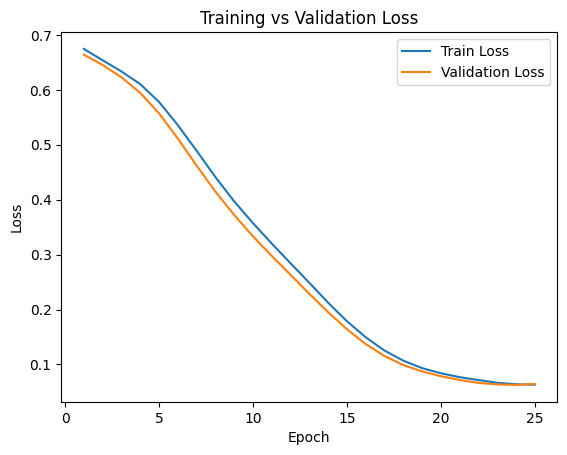

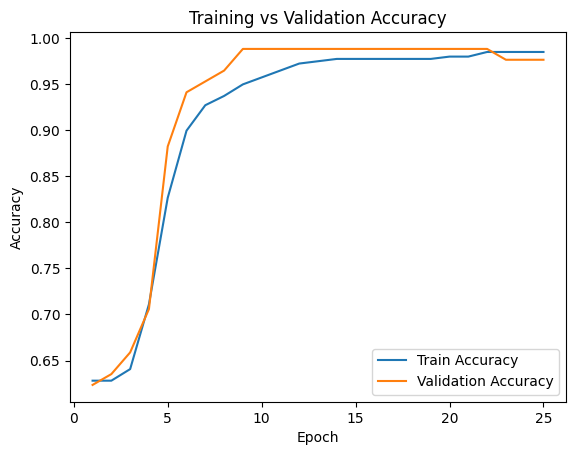

In [ ]:
# Cell 8 — Visualize training curves (loss graph + accuracy graph)

epochs_range = range(1, epochs + 1)

# Loss plot: training + validation on one graph
plt.figure()
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.plot(epochs_range, val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

# Accuracy plot: training + validation on one graph
plt.figure()
plt.plot(epochs_range, train_accs, label="Train Accuracy")
plt.plot(epochs_range, val_accs, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()


In [ ]:
# Cell 9 (Optional) — A quick look at overfitting/underfitting
# If validation loss rises while training loss falls, you're likely overfitting.

best_val_epoch = int(np.argmin(val_losses)) + 1
print(f"Best validation loss at epoch: {best_val_epoch}")
print(f"  Train loss: {train_losses[best_val_epoch-1]:.4f}")
print(f"  Val loss  : {val_losses[best_val_epoch-1]:.4f}")
print(f"  Train acc : {train_accs[best_val_epoch-1]:.4f}")
print(f"  Val acc   : {val_accs[best_val_epoch-1]:.4f}")


Best validation loss at epoch: 24
  Train loss: 0.0640
  Val loss  : 0.0627
  Train acc : 0.9849
  Val acc   : 0.9765
